In [211]:

import pandas as pd

import io
import os

import numpy as np

import datetime
from datetime import timedelta

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import plotly.express as px

import requests
import lxml
import html5lib

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import metrics
from scipy.spatial.distance import cdist
from bmdcluster import blockdiagonalBMD
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_samples, silhouette_score

In [212]:
directory_path = os.getcwd()
if not os.path.exists(directory_path+'//Результаты'):
    os.makedirs('Результаты')

In [213]:
bond_url = 'https://iss.moex.com/iss/apps/infogrid/emission/rates.csv?iss.dp=comma&iss.df=%25d.%25m.%25Y&iss.tf=%25H:%25M:%25S&iss.dtf=%25d.%25m.%25Y%25H:%25M:%25S&iss.only=rates&limit=unlimited&lang=ru'

In [214]:
req = requests.get(bond_url).content
raw_data = pd.read_csv(io.StringIO(req.decode('cp1251')), sep=';', header= 1)

In [215]:
### Предобработка
print('Форма данных:', raw_data.shape[0], 'строк и',raw_data.shape[1],'полей')

Форма данных: 2668 строк и 54 полей


In [216]:
raw_data.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2668 entries, 0 to 2667
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   SECID                   2668 non-null   object 
 1   SHORTNAME               2668 non-null   object 
 2   NAME                    2668 non-null   object 
 3   TYPENAME                2668 non-null   object 
 4   ISIN                    2668 non-null   object 
 5   REGNUMBER               2285 non-null   object 
 6   LISTLEVEL               2397 non-null   float64
 7   FACEVALUE               2668 non-null   object 
 8   FACEUNIT                2668 non-null   object 
 9   ISSUESIZE               2646 non-null   float64
 10  IS_COLLATERAL           2668 non-null   int64  
 11  IS_EXTERNAL             2668 non-null   int64  
 12  PRIMARY_BOARDID         2668 non-null   object 
 13  PRIMARY_BOARD_TITLE     2668 non-null   object 
 14  MATDATE                 2616 non-null   

In [217]:
# Пропущенные наблюдения
raw_data.isna().sum().sort_values(ascending = False).head(10)

IS_RII        2654
SECSUBTYPE    2511
OFFERDATE     2220
DISCOUNT3     1792
LIMIT2        1792
DISCOUNT2     1792
LIMIT1        1792
YIELDATWAP    1538
DURATION      1089
REGNUMBER      383
dtype: int64

In [218]:
# Ищем дубликаты
print(f'Дубликаты: {raw_data.iloc[:,1:].duplicated().sum()}, ({np.round(100*raw_data.iloc[:,1:].duplicated().sum()/len(raw_data),1)}%)')

Дубликаты: 0, (0.0%)


In [219]:
### Исправляем данные

## str, object -> float
# Значение купона должно быть числовым с точкой (float), в наборе данных - str. Из-за запятой

raw_data['COUPONPERCENT'] = raw_data['COUPONPERCENT'].str.replace(',','.').apply(float)
raw_data['COUPONPERCENT'].describe

# FACEVALUE
raw_data['FACEVALUE'] = raw_data['FACEVALUE'].str.replace(',','.').apply(float)
raw_data['FACEVALUE'].describe
# INITIALFACEVALUE
raw_data['INITIALFACEVALUE'] = raw_data['INITIALFACEVALUE'].str.replace(',','.').apply(float)
raw_data['INITIALFACEVALUE'].describe
# PRICE
raw_data['PRICE'] = raw_data['PRICE'].str.replace(',','.').apply(float)
raw_data['PRICE'].describe
# PRICE_RUB
raw_data['PRICE_RUB'] = raw_data['PRICE_RUB'].str.replace(',','.').apply(float)
raw_data['PRICE_RUB'].describe
# COUPONVALUE
raw_data['COUPONVALUE'] = raw_data['COUPONVALUE'].str.replace(',','.').apply(float)
raw_data['COUPONVALUE'].describe


## str, object -> datetime

# ISSUEDATE
raw_data['ISSUEDATE'] = pd.to_datetime(raw_data['ISSUEDATE'],format='%d.%m.%Y')
raw_data['COUPONDATE'] = pd.to_datetime(raw_data['COUPONDATE'],format='%d.%m.%Y')
raw_data['OFFERDATE'] = pd.to_datetime(raw_data['OFFERDATE'],format='%Y-%m-%d')
raw_data['MATDATE'] = pd.to_datetime(raw_data['MATDATE'],format='%d.%m.%Y')
# STARTDATEMOEX # есть пропуски
raw_data['STARTDATEMOEX'] = pd.to_datetime(raw_data['STARTDATEMOEX'],format='%Y-%m-%d')

In [220]:
### Первый подход к расчёту доходности
new_data = raw_data.copy()
print('До очистки',new_data.shape)
### Заполнение логических пропусков
new_data['COUPONLENGTH'].fillna(np.divide(365,new_data['COUPONFREQUENCY']),inplace = True)
new_data['COUPONFREQUENCY'].fillna(np.divide(365,new_data['COUPONLENGTH']),inplace = True)
new_data['COUPONVALUE'].fillna(new_data['COUPONPERCENT']*new_data['FACEVALUE']/100, inplace = True)
new_data = new_data.dropna(subset = ['COUPONVALUE','COUPONDAYSPASSED','COUPONLENGTH','PRICE','FACEVALUE','SECID','COUPONDATE','COUPONDAYSREMAIN','MATDATE','ISSUEDATE'])
print('После очистки', new_data.shape)
new_data['НКД'] = new_data['COUPONVALUE']*(np.divide(new_data['COUPONDAYSPASSED'],new_data['COUPONLENGTH']))
new_data['Годовой доход'] = (new_data['COUPONVALUE']*new_data['COUPONFREQUENCY'])*100 # в процентных пунктах!
new_data['Рыночная цена'] = new_data['PRICE']/100*new_data['FACEVALUE']
new_data[['ISIN','PRICE','FACEVALUE','COUPONDATE','COUPONDAYSPASSED','COUPONDAYSREMAIN']].head()
# Найдём исходную дату запроса - на случай технических проблем
check_date = ((new_data['COUPONDATE'][0])-datetime.timedelta(days=new_data['COUPONDAYSREMAIN'][0]))
# Нужно найти дату погашения или дату ближайшей оферты - смотря что ближе
for i in new_data.index:
    if new_data.loc[i,'OFFERDATE'] < new_data.loc[i,'MATDATE']:
        new_data.loc[i, 'Финальная дата'] = new_data.loc[i,'OFFERDATE']
    else:
        new_data.loc[i,'Финальная дата'] = new_data.loc[i,'MATDATE']


new_data['N оставшихся купонов'] = np.floor(np.divide((new_data['Финальная дата'] - check_date).astype('timedelta64[D]'),new_data['COUPONLENGTH']))
new_data['Валютный риск'] = 0

new_data['Годовой купон в %'] = (new_data['COUPONVALUE']*(new_data['COUPONFREQUENCY']))/(new_data['FACEVALUE'])*100 # в процентных пунктах!
new_data['Лет до погашения'] = (new_data['Финальная дата'] - check_date).astype('timedelta64[M]')/12
new_data['Срочность инструмента'] = (new_data['Финальная дата'] - new_data['ISSUEDATE']).astype('timedelta64[M]')/12
new_data = new_data[new_data['Финальная дата'] >= check_date]
new_data['Период НКД'] = new_data['COUPONDAYSPASSED']/new_data['COUPONLENGTH']
new_data['Переоценка в %'] = 100*(new_data['Рыночная цена']-new_data['FACEVALUE'])/new_data['FACEVALUE']
new_data['IS_RII'].replace('R',1,inplace = True)
new_data['IS_RII'].fillna(0,inplace = True)
new_data['LISTLEVEL'] = pd.Categorical(new_data['LISTLEVEL'])

До очистки (2668, 54)
После очистки (2293, 54)


In [221]:
### Пишем функцию для расчёта доходности
# https://journal.open-broker.ru/investments/formula-dlya-rascheta-dohodnosti-obligacij-k-pogasheniyu/
### входные параметры:
# df
# nkd_col - поле с накопленным купонным доходом в dataframe, в абсолютном выражении
# coup_val_col - поле с купонными доходами в абсолютном выражении
# market_price_col - поле с текущей рыночной ценой облигации, в абсолютном выражении
# nom_col - поле со значением номинала, в абсолютном выражении
# broker_fee_rate - ставка комиссии брокера, в процентах
# ex_fee_rate  - ставка комиссии биржи, в процентах
# tax_rate - ставка налога, в десятичных долях
# coupons_n_col - количество оставшихся купонов, в штуках
# final_date_col - дата оферты или погашения бумаги
def calc_bond_yield(
    df,
    nkd_col,
    coup_val_col,
    market_price_col,
    nom_col,
    coupons_n_col,
    broker_fee_rate,
    ex_fee_rate,
    tax_rate,
    final_date_col,
    check_date
    ):
    df['REALBONDYIELD'] = 0
    for i in df.index:
        if (df.loc[i,nom_col]>df.loc[i,market_price_col]):
            df.loc[i,'REALBONDYIELD'] = 100*np.divide(np.divide(((
                df.loc[i, nom_col] - df.loc[i, market_price_col])*(1-tax_rate) - df.loc[i,nkd_col] + (
                (1-tax_rate)*df.loc[i,coup_val_col]*(df.loc[i,coupons_n_col])    
                )),(
                    df.loc[i,market_price_col]+df.loc[i,nkd_col])*(1+broker_fee_rate/100+ex_fee_rate/100
                )),(df.loc[i,final_date_col] - check_date).days/365)
        else:
            df.loc[i,'REALBONDYIELD'] = 100*np.divide(np.divide(((
                df.loc[i, nom_col] - df.loc[i, market_price_col]) - df.loc[i,nkd_col] + (
                (1-tax_rate)*df.loc[i,coup_val_col]*df.loc[i,coupons_n_col]    
                )),(
                    df.loc[i,market_price_col]+df.loc[i,nkd_col])*(1+(broker_fee_rate/100)+(ex_fee_rate/100)
                )),(df.loc[i,final_date_col] - check_date).days/365)

In [222]:
calc_bond_yield(
    df = new_data, 
    nkd_col = 'НКД',
    coup_val_col = 'COUPONVALUE',
    market_price_col = 'Рыночная цена',
    nom_col = 'FACEVALUE',
    coupons_n_col = 'N оставшихся купонов',
    broker_fee_rate = 0.06,
    ex_fee_rate = 0.0125,
    tax_rate = 0.13,
    final_date_col = 'Финальная дата',
    check_date = check_date
    )


   Дата записи Контрольное время  Срочность  Значение КБД
0   2022-09-09          18:39:57       0.25        7.5867
1   2022-09-09          18:39:57       0.50        7.5920
2   2022-09-09          18:39:57       0.75        7.6066
3   2022-09-09          18:39:57       1.00        7.6282
4   2022-09-09          18:39:57       2.00        7.7654
5   2022-09-09          18:39:57       3.00        7.9519
6   2022-09-09          18:39:57       5.00        8.3553
7   2022-09-09          18:39:57       7.00        8.6999
8   2022-09-09          18:39:57      10.00        9.0549
9   2022-09-09          18:39:57      15.00        9.3363
10  2022-09-09          18:39:57      20.00        9.4755
11  2022-09-09          18:39:57      30.00        9.6386


Text(0.5, 0, 'Лет до погашения, в годах')

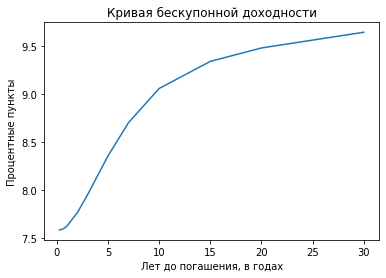

In [223]:
### Добавляем КБД
url = ('http://iss.moex.com/iss/engines/stock/zcyc.csv?iss.only=yearyields')

zcyc_data = requests.get(url).content
zcyc_data = pd.read_csv(io.StringIO(zcyc_data.decode('UTF-8')), sep = ';', header= 1)
zcyc_data.columns = ['Дата записи','Контрольное время', 'Срочность', 'Значение КБД']
print(zcyc_data)

plt.plot(zcyc_data['Срочность'], zcyc_data['Значение КБД'])
plt.title('Кривая бескупонной доходности')
plt.ylabel('Процентные пункты')
plt.xlabel('Лет до погашения, в годах')

In [224]:
def zcyc_match(df,zcyc_df, mat_column):
    for i in df.index:
        for j in range(len(zcyc_df)-1):
            if (df.loc[i,mat_column] > zcyc_df.loc[j,'Срочность']) & (df.loc[i,mat_column] <= zcyc_df.loc[j+1,'Срочность']):
                df.loc[i,'КБД'] = zcyc_df.loc[j,'Значение КБД']

In [225]:
zcyc_match(new_data,zcyc_data,'Лет до погашения')
new_data['Риск-премия'] = new_data['REALBONDYIELD'] - new_data['КБД']

In [226]:
new_data['TYPENAME'].value_counts()

Биржевые облигации             1607
Корпоративные еврооблигации     255
Корпоративные облигации         235
Региональные облигации          113
ОФЗ                              44
Облигации государств             16
Еврооблигации МинФина            14
Муниципальные облигации           9
Name: TYPENAME, dtype: int64

In [227]:
new_data['FACEUNIT'].value_counts()

RUB    2027
USD     222
EUR      32
CHF       7
CNY       3
GBP       2
Name: FACEUNIT, dtype: int64

count    2293.000000
mean        6.423426
std         5.550306
min         0.000000
25%         3.000000
50%         4.916667
75%         6.916667
max        91.083333
Name: Срочность инструмента, dtype: float64


Text(0, 0.5, 'N выпусков')

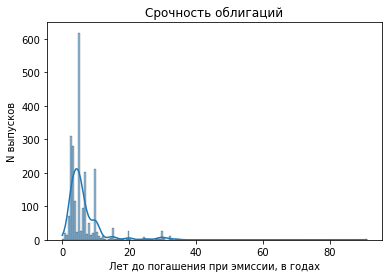

In [228]:
# На какой срок выпускали бумаги?
print(new_data['Срочность инструмента'].describe())
fig = sns.histplot(new_data, x = 'Срочность инструмента', kde = True)
plt.title('Срочность облигаций')
plt.xlabel('Лет до погашения при эмиссии, в годах')
plt.ylabel('N выпусков')


count    2293.000000
mean        3.211441
std         4.598879
min         0.000000
25%         0.916667
50%         2.166667
75%         3.583333
max        88.250000
Name: Лет до погашения, dtype: float64


Text(0, 0.5, 'N выпусков')

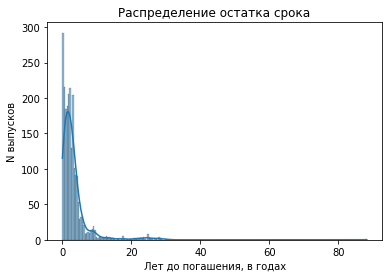

In [229]:
# Сколько осталось до погашения?
print(new_data['Лет до погашения'].describe())
fig = sns.histplot(new_data, x = 'Лет до погашения', kde = True)
plt.title('Распределение остатка срока')
plt.xlabel('Лет до погашения, в годах')
plt.ylabel('N выпусков')


count    2293.000000
mean        6.667968
std         5.104323
min         0.000100
25%         1.349961
50%         7.180000
75%         9.474000
max        45.014000
Name: Годовой купон в %, dtype: float64


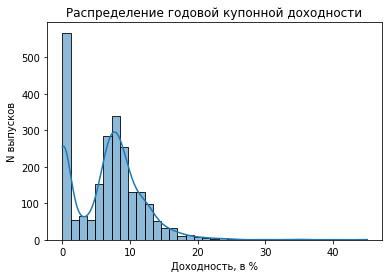

In [230]:
# Как распределена Годовой купон в %?
fig = sns.histplot(new_data, x = 'Годовой купон в %', kde = True)
plt.title('Распределение годовой купонной доходности')
plt.xlabel('Доходность, в %')
plt.ylabel('N выпусков')
print(new_data['Годовой купон в %'].describe())

<AxesSubplot:xlabel='Лет до погашения', ylabel='Годовой купон в %'>

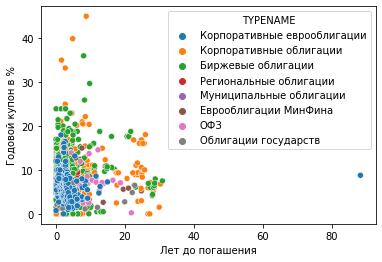

In [231]:
# Распределение облигаций по доходности и сроку погашения

sns.scatterplot(data = new_data, 
x = 'Лет до погашения', 
y = 'Годовой купон в %',
hue = 'TYPENAME')

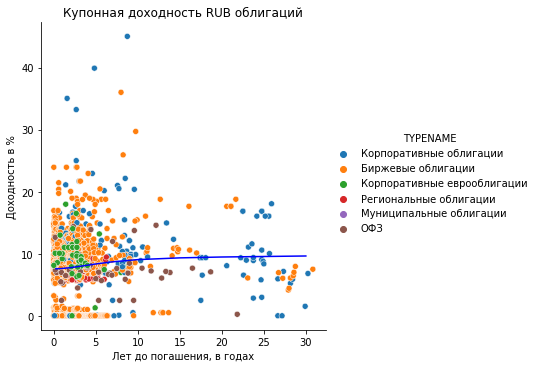

       Годовой купон в %  Лет до погашения
count        2027.000000       2027.000000
mean            6.889685          3.108781
std             5.303537          4.275316
min             0.000100          0.000000
25%             0.509990          0.916667
50%             7.577143          2.166667
75%             9.795356          3.416667
max            45.014000         30.833333


In [232]:
# RUB облигации
sns.relplot(data = new_data[new_data['FACEUNIT'] == 'RUB'], 
x = 'Лет до погашения', 
y = 'Годовой купон в %',
hue = 'TYPENAME',
)
plt.ylabel('Доходность в %')
plt.xlabel('Лет до погашения, в годах')
plt.title('Купонная доходность RUB облигаций')
plt.plot(zcyc_data['Срочность'], zcyc_data['Значение КБД'], color = 'b', label = 'КБД')
plt.show()
print(new_data[new_data['FACEUNIT'] == 'RUB'][['Годовой купон в %','Лет до погашения']].describe())

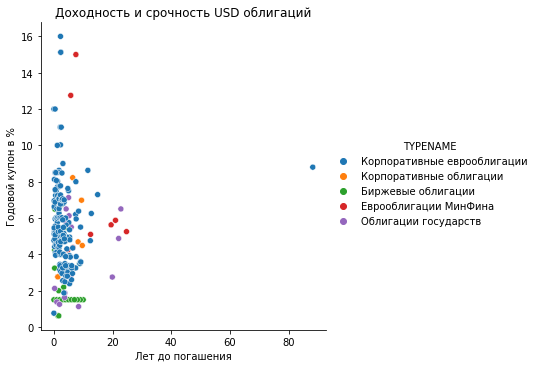

       Годовой купон в %  Лет до погашения
count         222.000000        222.000000
mean            5.307126          4.120120
std             2.649992          6.992977
min             0.614946          0.000000
25%             3.460000          1.270833
50%             5.058300          2.541667
75%             6.599100          4.750000
max            16.000000         88.250000


In [233]:
# Долларовые облигации
sns.relplot(data = new_data[new_data['FACEUNIT'] == 'USD'], 
x = 'Лет до погашения', 
y = 'Годовой купон в %',
hue = 'TYPENAME',
)
plt.title('Доходность и срочность USD облигаций')
plt.show()
print(new_data[new_data['FACEUNIT'] == 'USD'][['Годовой купон в %','Лет до погашения']].describe())

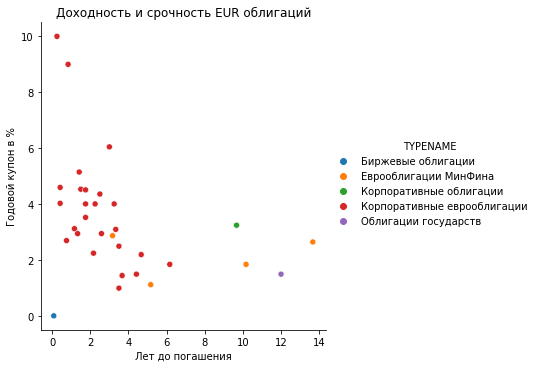

       Годовой купон в %  Лет до погашения
count          32.000000         32.000000
mean            3.395030          3.507812
std             2.088287          3.405033
min             0.010000          0.083333
25%             2.112500          1.395833
50%             3.025000          2.541667
75%             4.115000          3.854167
max            10.000000         13.666667


In [234]:
# Евро облигации
sns.relplot(data = new_data[new_data['FACEUNIT'] == 'EUR'], 
x = 'Лет до погашения', 
y = 'Годовой купон в %',
hue = 'TYPENAME',
)
plt.title('Доходность и срочность EUR облигаций')
plt.show()
print(new_data[new_data['FACEUNIT'] == 'EUR'][['Годовой купон в %','Лет до погашения']].describe())

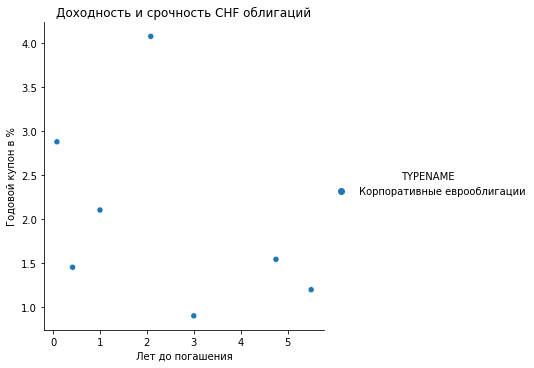

       Годовой купон в %  Лет до погашения
count           7.000000          7.000000
mean            2.018657          2.404762
std             1.113956          2.115545
min             0.898000          0.083333
25%             1.322500          0.708333
50%             1.540000          2.083333
75%             2.487500          3.875000
max             4.072600          5.500000


In [235]:
# CHF облигации
sns.relplot(data = new_data[new_data['FACEUNIT'] == 'CHF'], 
x = 'Лет до погашения', 
y = 'Годовой купон в %',
hue = 'TYPENAME',
)
plt.title('Доходность и срочность CHF облигаций')
plt.show()
print(new_data[new_data['FACEUNIT'] == 'CHF'][['Годовой купон в %','Лет до погашения']].describe())

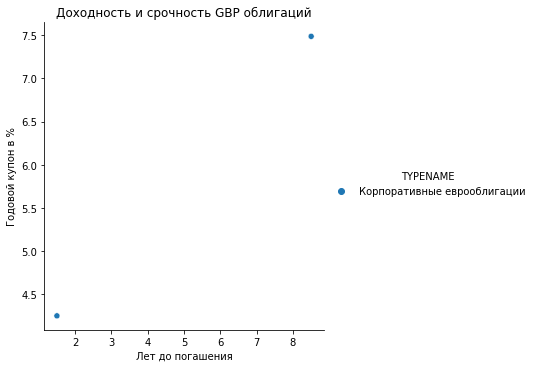

       Годовой купон в %  Лет до погашения
count           2.000000          2.000000
mean            5.868500          5.000000
std             2.288905          4.949747
min             4.250000          1.500000
25%             5.059250          3.250000
50%             5.868500          5.000000
75%             6.677750          6.750000
max             7.487000          8.500000


In [236]:
# GBP облигации
sns.relplot(data = new_data[new_data['FACEUNIT'] == 'GBP'], 
x = 'Лет до погашения', 
y = 'Годовой купон в %',
hue = 'TYPENAME',
)
plt.title('Доходность и срочность GBP облигаций')
plt.show()
print(new_data[new_data['FACEUNIT'] == 'GBP'][['Годовой купон в %','Лет до погашения']].describe())

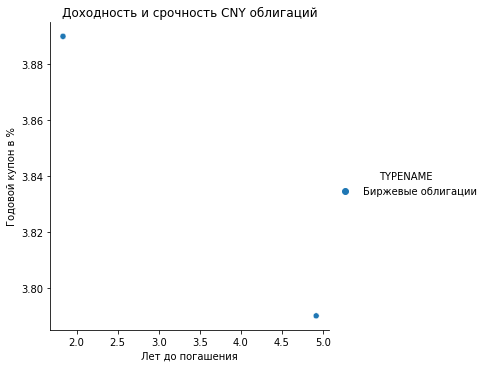

       Годовой купон в %  Лет до погашения
count           3.000000          3.000000
mean            3.856667          2.861111
std             0.057735          1.780163
min             3.790000          1.833333
25%             3.840000          1.833333
50%             3.890000          1.833333
75%             3.890000          3.375000
max             3.890000          4.916667


In [237]:
# CNY облигации
sns.relplot(data = new_data[new_data['FACEUNIT'] == 'CNY'], 
x = 'Лет до погашения', 
y = 'Годовой купон в %',
hue = 'TYPENAME',
)
plt.title('Доходность и срочность CNY облигаций')
plt.show()
print(new_data[new_data['FACEUNIT'] == 'CNY'][['Годовой купон в %','Лет до погашения']].describe())

In [238]:
pd.pivot_table(new_data, values = 'SECID', index = 'TYPENAME', columns = 'FACEUNIT', aggfunc = 'count')

FACEUNIT,CHF,CNY,EUR,GBP,RUB,USD
TYPENAME,,,,,,
Биржевые облигации,NaN,3.0,1.0,NaN,1575.0,28.0
Еврооблигации МинФина,NaN,NaN,4.0,NaN,NaN,10.0
Корпоративные еврооблигации,7.0,NaN,25.0,2.0,60.0,161.0
Корпоративные облигации,NaN,NaN,1.0,NaN,226.0,8.0
Муниципальные облигации,NaN,NaN,NaN,NaN,9.0,NaN
ОФЗ,NaN,NaN,NaN,NaN,44.0,NaN
Облигации государств,NaN,NaN,1.0,NaN,NaN,15.0
Региональные облигации,NaN,NaN,NaN,NaN,113.0,NaN


[Text(0.5, 1.0, 'Спектральные кластеры')]

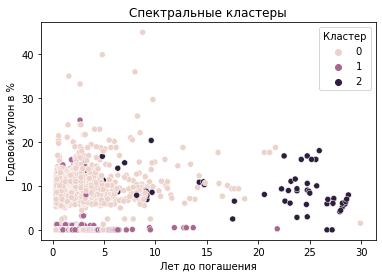

In [239]:
### Ищем кластеры - по валютам!
clusters_data = new_data[['SECID','LISTLEVEL','HIGH_RISK','IS_RII','Годовой купон в %','N оставшихся купонов','Лет до погашения','Срочность инструмента','Переоценка в %','REALBONDYIELD','Риск-премия']][new_data['FACEUNIT'] == 'RUB']
clusters_data = clusters_data.set_index('SECID')
clusters_data.dropna(inplace= True)

spectral_cluster_model = SpectralClustering(
    n_clusters = 3,
    random_state= 1481,
    n_neighbors= 10,
    affinity = 'nearest_neighbors'
)
clusters_data['Кластер'] = spectral_cluster_model.fit_predict(clusters_data[['LISTLEVEL','HIGH_RISK','IS_RII','Годовой купон в %','N оставшихся купонов','Лет до погашения','Срочность инструмента','Переоценка в %','REALBONDYIELD','Риск-премия']])
fig, ax = plt.subplots()
sns.scatterplot(x='Лет до погашения', y='Годовой купон в %', data=clusters_data, hue='Кластер', ax=ax)
ax.set(title='Спектральные кластеры')

In [240]:
clusters_data.isna().sum()

LISTLEVEL                0
HIGH_RISK                0
IS_RII                   0
Годовой купон в %        0
N оставшихся купонов     0
Лет до погашения         0
Срочность инструмента    0
Переоценка в %           0
REALBONDYIELD            0
Риск-премия              0
Кластер                  0
dtype: int64

Для числа кластеров = 2 Среднее значение силуэта : 0.985111273490636
Для числа кластеров = 3 Среднее значение силуэта : 0.9669000367129073
Для числа кластеров = 4 Среднее значение силуэта : 0.9636734071605054
Для числа кластеров = 5 Среднее значение силуэта : 0.7389117300529804
Для числа кластеров = 6 Среднее значение силуэта : 0.7456167937652944
Для числа кластеров = 7 Среднее значение силуэта : 0.7404732244469575
Для числа кластеров = 8 Среднее значение силуэта : 0.41836151012971323
Для числа кластеров = 9 Среднее значение силуэта : 0.4202067531669428
Для числа кластеров = 10 Среднее значение силуэта : 0.4204808259906699


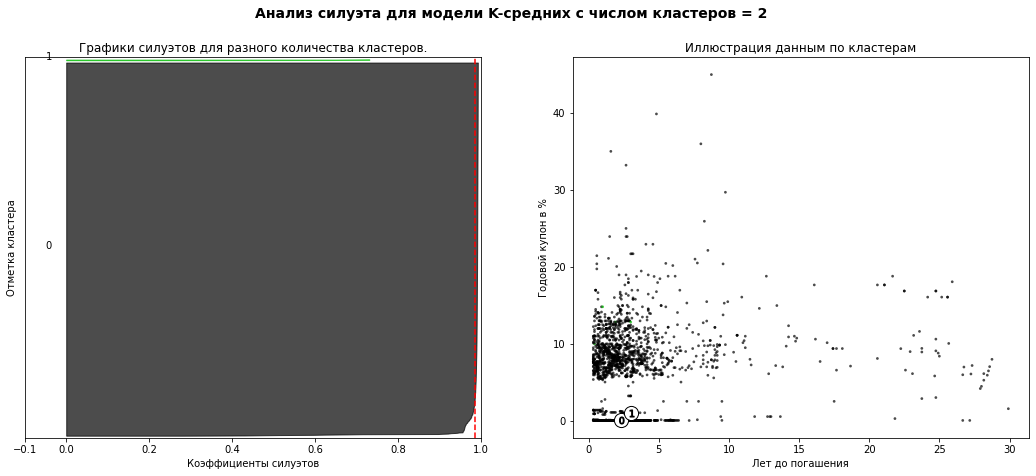

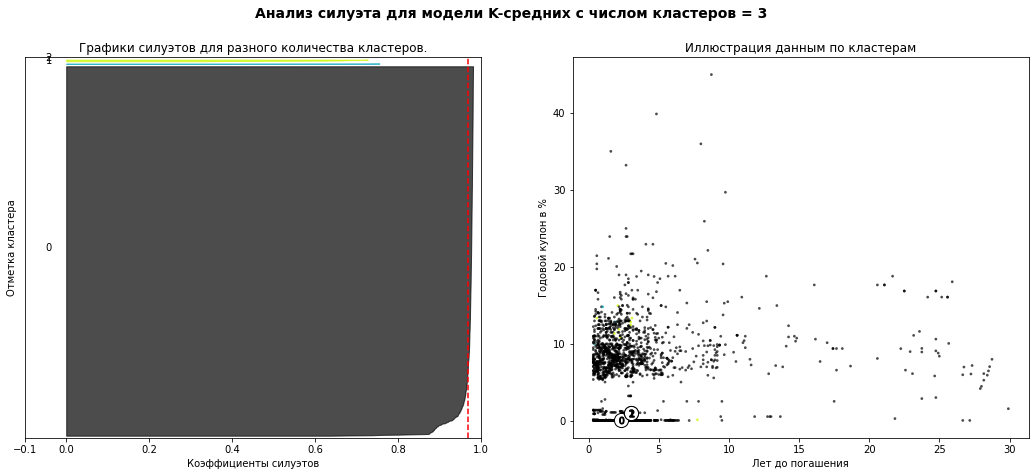

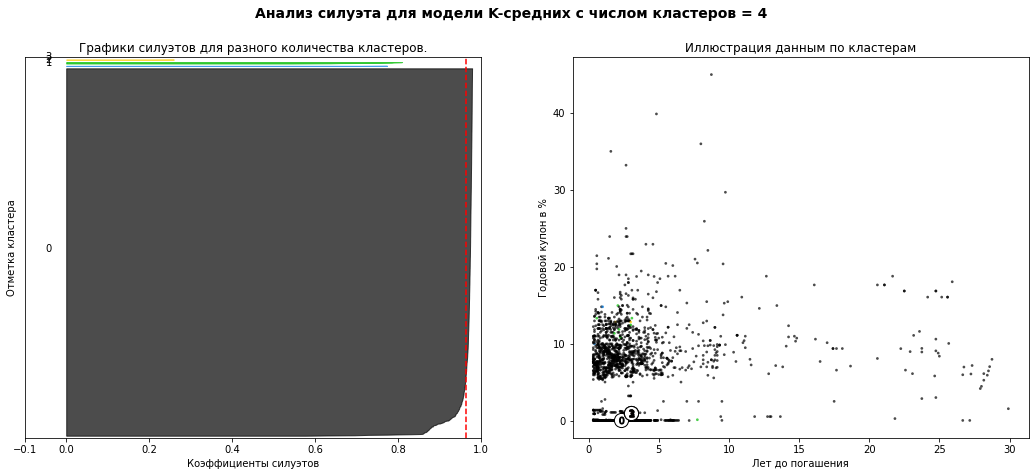

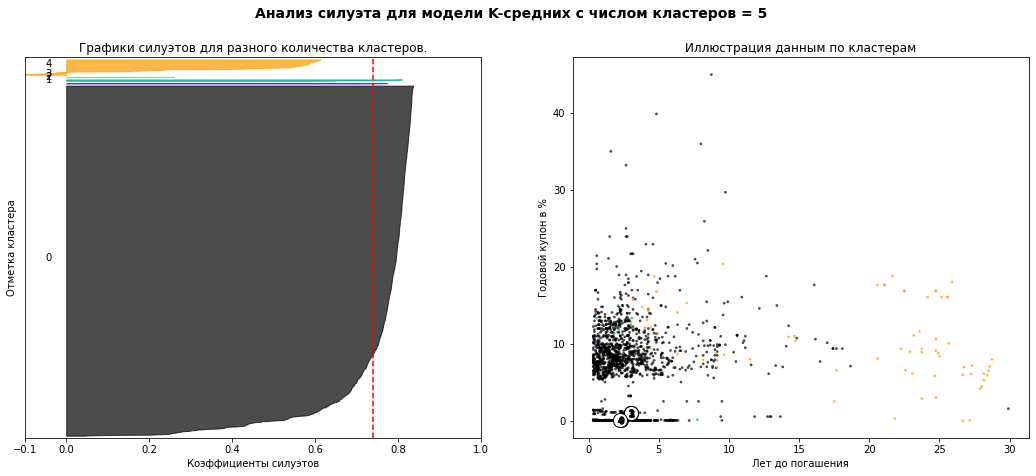

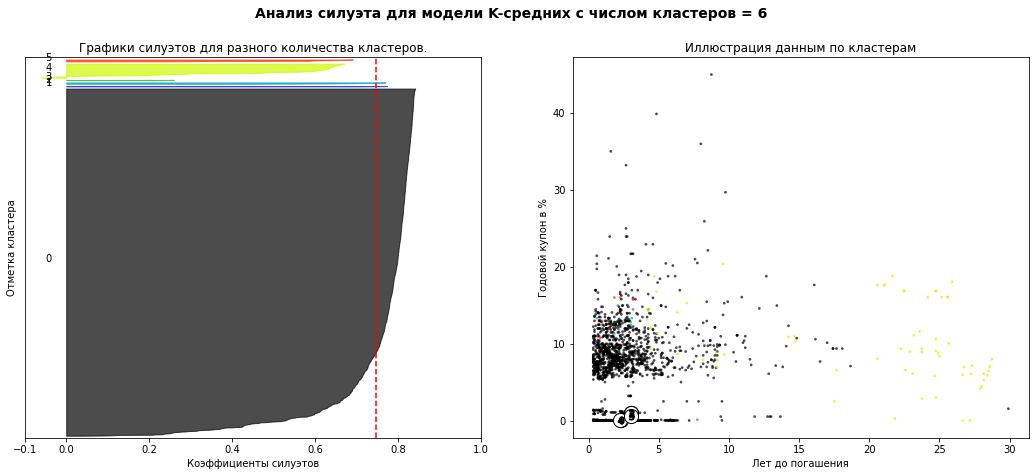

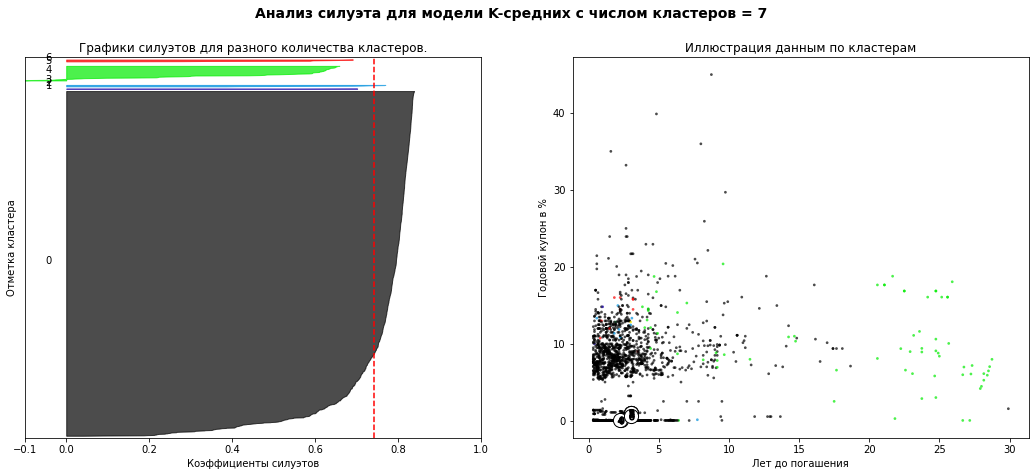

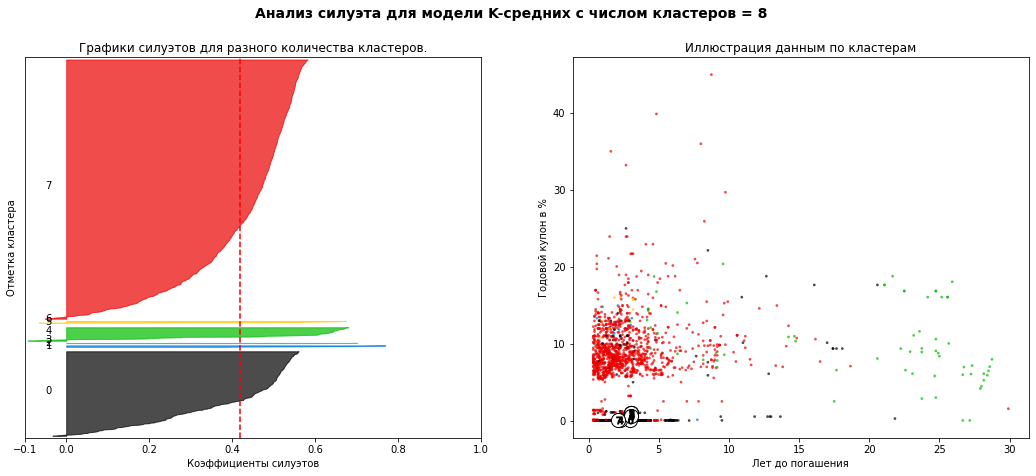

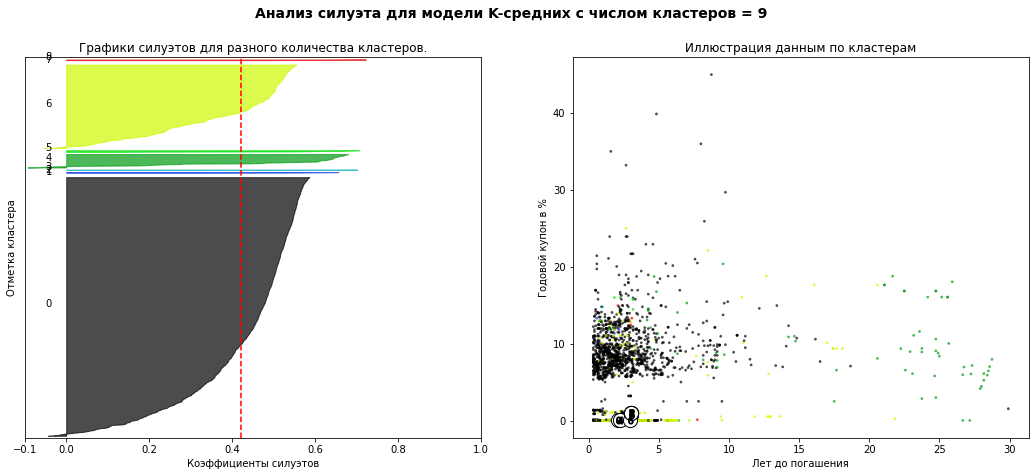

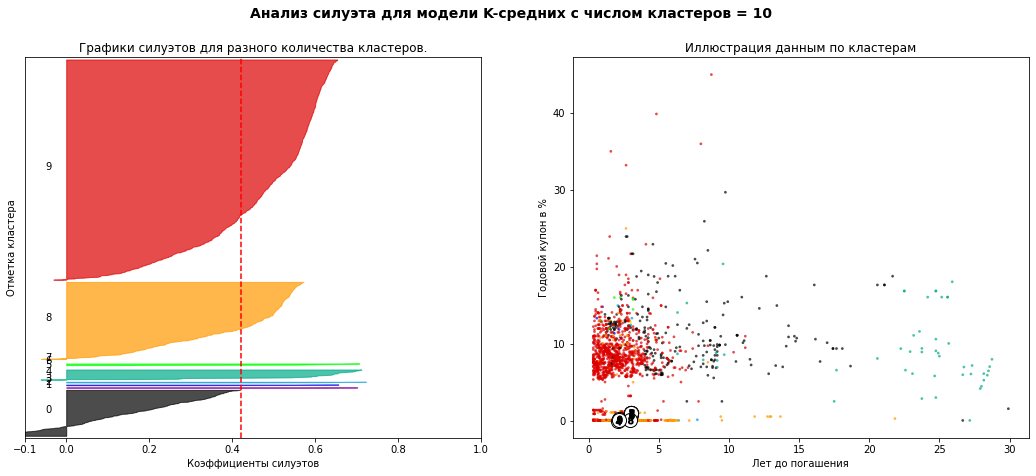

In [248]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(clusters_data) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(clusters_data)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(clusters_data, cluster_labels)
    print(
        "Для числа кластеров =",
        n_clusters,
        "Среднее значение силуэта :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(clusters_data, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Графики силуэтов для разного количества кластеров.")
    ax1.set_xlabel("Коэффициенты силуэтов")
    ax1.set_ylabel("Отметка кластера")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        clusters_data.loc[:, 'Лет до погашения'], clusters_data.loc[:, 'Годовой купон в %'], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("Иллюстрация данным по кластерам")
    ax2.set_xlabel("Лет до погашения")
    ax2.set_ylabel("Годовой купон в %")

    plt.suptitle(
        "Анализ силуэта для модели K-средних с числом кластеров = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

In [242]:
from OptimalCluster.opticlust import Optimal
opt = Optimal()
opt_sil_value = opt.silhouette(clusters_data)

Optimal number of clusters is:  2


Часть вторая: отбор оптимальных облигаций

In [243]:
### Отбираем низкий риск
## Первый котировальный список
## Валюта - строго RUB
## SECSUBTYPE - пропуск, т.к. сложные продукты
## HIGH_RISK == 0
## IS_QUALIFIED_INVESTORS == 0
## Премия от КБД > 0 и < 5 п.п.

final_data = new_data[new_data['Период НКД'] >= 0.2]
final_data = final_data[
    (new_data['LISTLEVEL'] == 1)&
    (new_data['FACEUNIT']=='RUB')&
    (new_data['HIGH_RISK']==0)&
    (new_data['SECSUBTYPE'].isna())&
    (new_data['IS_QUALIFIED_INVESTORS'] == 0)&
    (new_data['REALBONDYIELD']>0)&
    (abs(new_data['Переоценка в %'])<=10)&
    (new_data['Риск-премия']>0)&
    (new_data['Риск-премия']<0.5*new_data['КБД'])]
final_data = final_data[['SECID','TYPENAME','Лет до погашения','REALBONDYIELD','Финальная дата','FACEVALUE','Рыночная цена','Переоценка в %','COUPONVALUE','Годовой купон в %','НКД','КБД','Риск-премия']]
final_data.sort_values(by = 'REALBONDYIELD',ascending=False).head(10)

C:\Users\mikha\AppData\Local\Temp\ipykernel_6360\3607872362.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  final_data = final_data[


,SECID,TYPENAME,Лет до погашения,REALBONDYIELD,Финальная дата,FACEVALUE,Рыночная цена,Переоценка в %,COUPONVALUE,Годовой купон в %,НКД,КБД,Риск-премия
2165,RU000A104U68,Биржевые облигации,9.666667,12.030011,2032-05-14,1000.0,1000.0,0.00,76.34,15.268,44.461758,8.6999,3.330111
482,RU000A0ZYJJ3,Биржевые облигации,5.166667,10.761976,2027-11-24,1000.0,1016.0,1.60,74.79,14.958,41.504341,8.3553,2.406676
440,RU000A0ZYCP5,Биржевые облигации,2.000000,10.675249,2024-10-08,1000.0,1017.7,1.77,100.22,20.044,85.902857,7.6282,3.047049
15,RU000A0JQAM6,Корпоративные облигации,6.000000,10.631737,2028-09-15,1000.0,1099.7,9.97,100.82,20.164,98.080326,8.3553,2.276437
481,RU000A0ZYJH7,Биржевые облигации,5.166667,10.514817,2027-11-24,1000.0,1024.8,2.48,74.79,14.958,41.504341,8.3553,2.159517
2297,SU29010RMFS4,ОФЗ,12.166667,10.070377,2034-12-06,1000.0,1097.3,9.73,72.95,14.590,32.065934,9.0549,1.015477
2207,RU000A104YT6,Биржевые облигации,2.833333,9.636432,2025-07-11,1000.0,1012.8,1.28,33.03,13.212,20.689121,7.7654,1.871032
2296,SU29009RMFS6,ОФЗ,9.583333,9.327750,2032-05-05,1000.0,1079.8,7.98,68.71,13.742,43.415659,8.6999,0.627850
940,RU000A101798,Биржевые облигации,7.166667,8.926510,2029-12-06,1000.0,1038.6,3.86,62.33,12.466,29.452637,8.6999,0.226610
1908,RU000A103RT2,Биржевые облигации,2.000000,8.697172,2024-09-24,1000.0,959.0,-4.10,22.44,8.976,18.247912,7.6282,1.068972


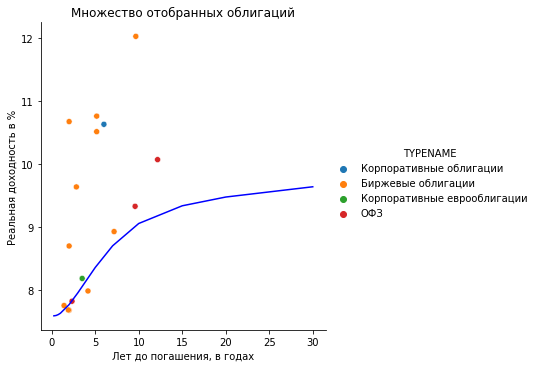

       REALBONDYIELD  Лет до погашения
count      16.000000         16.000000
mean        9.272468          4.817708
std         1.385104          3.301125
min         7.675604          1.416667
25%         7.941121          2.000000
50%         9.127130          3.833333
75%        10.544047          6.291667
max        12.030011         12.166667


In [244]:
sns.relplot(data = final_data, 
x = 'Лет до погашения', 
y = 'REALBONDYIELD',
hue = 'TYPENAME',
legend = 'full'
)
plt.ylabel('Реальная доходность в %')
plt.xlabel('Лет до погашения, в годах')
plt.title('Множество отобранных облигаций')
plt.plot(zcyc_data['Срочность'], zcyc_data['Значение КБД'], color = 'b', label = 'КБД')
plt.show()
print(final_data[['REALBONDYIELD','Лет до погашения']].describe())

In [245]:
top_10_bonds = final_data.sort_values(by = 'REALBONDYIELD',ascending=False).head(10)
top_10_bonds

,SECID,TYPENAME,Лет до погашения,REALBONDYIELD,Финальная дата,FACEVALUE,Рыночная цена,Переоценка в %,COUPONVALUE,Годовой купон в %,НКД,КБД,Риск-премия
2165,RU000A104U68,Биржевые облигации,9.666667,12.030011,2032-05-14,1000.0,1000.0,0.00,76.34,15.268,44.461758,8.6999,3.330111
482,RU000A0ZYJJ3,Биржевые облигации,5.166667,10.761976,2027-11-24,1000.0,1016.0,1.60,74.79,14.958,41.504341,8.3553,2.406676
440,RU000A0ZYCP5,Биржевые облигации,2.000000,10.675249,2024-10-08,1000.0,1017.7,1.77,100.22,20.044,85.902857,7.6282,3.047049
15,RU000A0JQAM6,Корпоративные облигации,6.000000,10.631737,2028-09-15,1000.0,1099.7,9.97,100.82,20.164,98.080326,8.3553,2.276437
481,RU000A0ZYJH7,Биржевые облигации,5.166667,10.514817,2027-11-24,1000.0,1024.8,2.48,74.79,14.958,41.504341,8.3553,2.159517
2297,SU29010RMFS4,ОФЗ,12.166667,10.070377,2034-12-06,1000.0,1097.3,9.73,72.95,14.590,32.065934,9.0549,1.015477
2207,RU000A104YT6,Биржевые облигации,2.833333,9.636432,2025-07-11,1000.0,1012.8,1.28,33.03,13.212,20.689121,7.7654,1.871032
2296,SU29009RMFS6,ОФЗ,9.583333,9.327750,2032-05-05,1000.0,1079.8,7.98,68.71,13.742,43.415659,8.6999,0.627850
940,RU000A101798,Биржевые облигации,7.166667,8.926510,2029-12-06,1000.0,1038.6,3.86,62.33,12.466,29.452637,8.6999,0.226610
1908,RU000A103RT2,Биржевые облигации,2.000000,8.697172,2024-09-24,1000.0,959.0,-4.10,22.44,8.976,18.247912,7.6282,1.068972


In [246]:
top_1q_bonds = final_data[final_data['Лет до погашения'] <= 0.25]
top_h_bonds = final_data[(final_data['Лет до погашения'] <= 0.5)&(final_data['Лет до погашения'] > 0.25)]
top_3q_bonds = final_data[(final_data['Лет до погашения'] <= 0.75)&(final_data['Лет до погашения'] > 0.5)]
top_1y_bonds = final_data[(final_data['Лет до погашения'] <= 1)&(final_data['Лет до погашения'] > 0.75)]
top_2y_bonds = final_data[(final_data['Лет до погашения'] <= 2)&(final_data['Лет до погашения'] > 1)]
top_3y_bonds = final_data[(final_data['Лет до погашения'] <= 3)&(final_data['Лет до погашения'] > 2)]
top_5y_bonds = final_data[(final_data['Лет до погашения'] <= 5)&(final_data['Лет до погашения'] > 3)]
top_7y_bonds = final_data[(final_data['Лет до погашения'] <= 7)&(final_data['Лет до погашения'] > 5)]
top_10y_bonds = final_data[(final_data['Лет до погашения'] <= 10)&(final_data['Лет до погашения'] > 7)]
top_15y_bonds = final_data[(final_data['Лет до погашения'] <= 15)&(final_data['Лет до погашения'] > 10)]
top_20y_bonds = final_data[(final_data['Лет до погашения'] <= 20)&(final_data['Лет до погашения'] > 15)]
top_30y_bonds = final_data[(final_data['Лет до погашения'] <= 30)&(final_data['Лет до погашения'] > 20)]

In [247]:

from time import strftime


with pd.ExcelWriter(directory_path+'\\'+r'Результаты'+'\\Анализ облигаций РМА ' + datetime.datetime.now().strftime('%Y %m %d %H-%M-%S') +  '.xlsx', mode='w') as writer:    
    final_data.to_excel(writer, sheet_name = 'Выборка', index = False)
    zcyc_data.to_excel(writer, sheet_name = 'КБД', index = False)
    top_h_bonds.to_excel(writer, sheet_name='До 6 м', index = False)
    top_3q_bonds.to_excel(writer, sheet_name='До 9 м', index = False)
    top_1y_bonds.to_excel(writer, sheet_name='До 1 г', index = False)
    top_2y_bonds.to_excel(writer, sheet_name='До 2 л', index = False)
    top_3y_bonds.to_excel(writer, sheet_name='До 3 л', index = False)
